<a href="https://colab.research.google.com/github/alanrbtx/dl_lab1/blob/main/lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# https://www.kaggle.com/discussions/general/74235
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d jessicali9530/stanford-cars-dataset
! unzip -q stanford-cars-dataset.zip -d stanford-cars-dataset

100% 1.82G/1.82G [01:25<00:00, 24.0MB/s]
100% 1.82G/1.82G [01:25<00:00, 22.9MB/s]


In [3]:
! mkdir annotations

In [4]:
! wget -P annotations/ https://github.com/alanrbtx/dl_lab1/raw/main/annotations/cars_meta.mat
! wget -P annotations/ https://github.com/alanrbtx/dl_lab1/raw/main/annotations/cars_train_annos.mat
! wget -P annotations/ https://github.com/alanrbtx/dl_lab1/raw/main/annotations/cars_test_annos_withlabels_eval.mat

--2023-11-11 21:10:03--  https://github.com/alanrbtx/dl_lab1/raw/main/annotations/cars_meta.mat
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/alanrbtx/dl_lab1/main/annotations/cars_meta.mat [following]
--2023-11-11 21:10:03--  https://raw.githubusercontent.com/alanrbtx/dl_lab1/main/annotations/cars_meta.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3177 (3.1K) [application/octet-stream]
Saving to: ‘annotations/cars_meta.mat’

cars_meta.mat       100%[===================>]   3.10K  --.-KB/s    in 0s      

2023-11-11 21:10:04 (45.9 MB/s) - ‘annotations/cars_meta.mat’ saved [3177/3177]

# Custom Dataset

In [5]:
from torch.utils.data import Dataset, DataLoader
from typing import Callable
from scipy.io import loadmat
from PIL import Image
import os
class CarsDataset(Dataset):
    def __init__(self, imgs_dir: str, annos_path: str, transforms: Callable = None):
        self.imgs_paths = self.__load_imgs_paths(imgs_dir)
        self.labels = self.__load_labels(annos_path)
        self.transforms = transforms

    def __load_imgs_paths(self, dir):
        return [os.path.join(dir, filename) for filename in os.listdir(dir) if os.path.isfile(os.path.join(dir, filename))]

    def __load_labels(self, path):
        mat = loadmat(path)
        labels = {}

        for arr in mat['annotations'][0]:
            filename, label = str(arr[5][0]), int(arr[4][0,0])-1
            labels[filename] = label

        return labels

    def __len__(self):
        return len(self.imgs_paths)

    def __getitem__(self, index):
        img_path = self.imgs_paths[index]
        img = Image.open(img_path).convert('RGB')
        label = self.labels[os.path.basename(img_path)]

        if self.transforms:
            img = self.transforms(img)

        return img, label

In [6]:
def load_class_names(path):
    return [str(arr[0]) for arr in loadmat(path)['class_names'][0]]

In [7]:
from torchvision.transforms import v2

transforms = v2.Compose([
    v2.Resize((227, 227)),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [8]:
train_dataset = CarsDataset(imgs_dir = './stanford-cars-dataset/cars_train/cars_train',
                            annos_path = './annotations/cars_train_annos.mat',
                            transforms = transforms)
test_dataset = CarsDataset(imgs_dir = './stanford-cars-dataset/cars_test/cars_test',
                           annos_path ='./annotations/cars_test_annos_withlabels_eval.mat',
                           transforms = transforms)

In [9]:
class_names = load_class_names('./annotations/cars_meta.mat')
train_loader = DataLoader(dataset=train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=512, shuffle=True)

# Train and test loops

In [10]:
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
from tqdm import tqdm

def train_one_epoch(model: torch.nn.Module, loader: DataLoader, optimizer, loss_fn):
    running_loss = 0.

    # training mode
    model.train(True)

    for i, data in enumerate(tqdm(loader)):
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # обнуление градиентов
        optimizer.zero_grad()

        # предсказание
        outputs = model(inputs)

        # считаем ошибку и градиенты
        loss = loss_fn(outputs, labels)
        loss.backward()

        # обновление весов
        optimizer.step()

        running_loss += loss.item()

    return running_loss / len(loader)

In [12]:
! pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.3 MB/s eta 0:00:00


In [13]:
from torcheval.metrics.functional import multiclass_f1_score, multiclass_accuracy

def validate(model, loader, loss_fn):
    running_vloss = 0.0
    pred_labels_ids = torch.Tensor().type(torch.int64)
    true_labels_ids = torch.Tensor().type(torch.int64)

    # evaluation mode
    model.eval()

    # disable gradient computation
    with torch.no_grad():
        for i, vdata in enumerate(loader):
            vinputs, vlabels = vdata

            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)

            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)

            running_vloss += vloss.item()
            true_labels_ids = torch.cat((true_labels_ids, vlabels.cpu().squeeze()))
            pred_labels_ids = torch.cat((pred_labels_ids, voutputs.cpu().argmax(dim=-1, keepdim=False)))

    # compute loss and metrics
    avg_vloss = running_vloss / len(loader)
    accuracy = multiclass_accuracy(pred_labels_ids, true_labels_ids)
    f1 = multiclass_f1_score(pred_labels_ids, true_labels_ids, num_classes=len(class_names), average='weighted')
    f1_macro = multiclass_f1_score(pred_labels_ids, true_labels_ids, num_classes=len(class_names), average='macro')

    return avg_vloss, accuracy.detach().numpy(), f1.detach().numpy(), f1_macro.detach().numpy()

In [14]:
def train_loop(model, train_loader, test_loader, optimizer, loss_fn, prefix, epochs=10):
    best_vloss = 1e10

    history = {'Train loss': [], 'Valid loss': [], 'Accuracy': [], 'F1': [], 'F1 macro': []}

    for epoch_number in range(epochs):
        print(f'\nEpoch {epoch_number+1}:')

        avg_loss = train_one_epoch(model, train_loader, optimizer, loss_fn)
        avg_vloss, accuracy, f1, f1_macro = validate(model, test_loader, loss_fn)

        print('\n\U0001f600 LOSS train: {} valid {}'.format(avg_loss, avg_vloss))
        print('Accuracy:', accuracy)
        print('F1:', f1)
        print('F1 macro:', f1_macro)

        history['Train loss'].append(avg_loss)
        history['Valid loss'].append(avg_vloss)
        history['Accuracy'].append(accuracy)
        history['F1'].append(f1)
        history['F1 macro'].append(f1_macro)

        # save best model
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            model_path = f'{prefix}_{epoch_number+1}'
            torch.save(model.state_dict(), model_path)

    return history

In [15]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.plot(history['Train loss'])
    plt.plot(history['Valid loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

    plt.plot(history['Accuracy'])
    plt.plot(history['F1'])
    plt.plot(history['F1 macro'])
    plt.title('metrics')
    plt.ylabel('metrics')
    plt.xlabel('epoch')
    plt.legend(['Accuracy', 'F1', 'F1 macro'], loc='upper left')
    plt.show()

# Model

In [16]:
import torch

class AlexNet(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv_stack = torch.nn.Sequential(
            torch.nn.Conv2d(3, 96, kernel_size=11, stride=4),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            torch.nn.Conv2d(96, 256, 5, stride=1, padding=2),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
            torch.nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        )

        self.flatten = torch.nn.Flatten()

        self.classification_head = torch.nn.Sequential(
            torch.nn.Dropout(p=0.5, inplace=False),
            torch.nn.Linear(9216, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Dropout(p=0.5, inplace=False),
            torch.nn.Linear(4096, 4096),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.conv_stack(x)
        x = self.flatten(x)
        x = self.classification_head(x)
        return x

# Training


Epoch 1:


100%|██████████| 16/16 [01:36<00:00,  6.05s/it]



😀 LOSS train: 5.282082557678223 valid 5.276631742715836
Accuracy: 0.0084566595
F1: 0.00014183077
F1 macro: 8.556881e-05

Epoch 2:


100%|██████████| 16/16 [01:21<00:00,  5.09s/it]



😀 LOSS train: 5.280161947011948 valid 5.276241183280945
Accuracy: 0.0084566595
F1: 0.00014183077
F1 macro: 8.556881e-05

Epoch 3:


100%|██████████| 16/16 [01:33<00:00,  5.85s/it]



😀 LOSS train: 5.277574867010117 valid 5.275345116853714
Accuracy: 0.0084566595
F1: 0.00014183077
F1 macro: 8.556881e-05

Epoch 4:


100%|██████████| 16/16 [01:21<00:00,  5.12s/it]



😀 LOSS train: 5.24630931019783 valid 5.218233734369278
Accuracy: 0.01268499
F1: 0.00084573135
F1 macro: 0.0007721673

Epoch 5:


100%|██████████| 16/16 [01:19<00:00,  4.95s/it]



😀 LOSS train: 5.195437848567963 valid 5.167781502008438
Accuracy: 0.009700286
F1: 0.00034834445
F1 macro: 0.0002860793

Epoch 6:


100%|██████████| 16/16 [01:20<00:00,  5.01s/it]



😀 LOSS train: 5.149523615837097 valid 5.14054998755455
Accuracy: 0.0125606265
F1: 0.00093743426
F1 macro: 0.0008316436

Epoch 7:


100%|██████████| 16/16 [01:19<00:00,  4.98s/it]



😀 LOSS train: 5.127253919839859 valid 5.123828858137131
Accuracy: 0.012436264
F1: 0.0014892208
F1 macro: 0.0013534874

Epoch 8:


100%|██████████| 16/16 [01:20<00:00,  5.01s/it]



😀 LOSS train: 5.103567063808441 valid 5.118715763092041
Accuracy: 0.013058078
F1: 0.001936128
F1 macro: 0.0017918479

Epoch 9:


100%|██████████| 16/16 [01:20<00:00,  5.04s/it]



😀 LOSS train: 5.08342319726944 valid 5.113843202590942
Accuracy: 0.015794056
F1: 0.0032543128
F1 macro: 0.003014289

Epoch 10:


100%|██████████| 16/16 [01:19<00:00,  4.98s/it]



😀 LOSS train: 5.0578140914440155 valid 5.096773475408554
Accuracy: 0.014674792
F1: 0.0036373758
F1 macro: 0.003546218

Epoch 11:


100%|██████████| 16/16 [01:20<00:00,  5.00s/it]



😀 LOSS train: 5.033122539520264 valid 5.106125742197037
Accuracy: 0.016664594
F1: 0.00485571
F1 macro: 0.0046809153

Epoch 12:


100%|██████████| 16/16 [01:19<00:00,  4.97s/it]



😀 LOSS train: 5.004753947257996 valid 5.095382332801819
Accuracy: 0.019898023
F1: 0.0071028797
F1 macro: 0.006844569

Epoch 13:


100%|██████████| 16/16 [01:19<00:00,  4.97s/it]



😀 LOSS train: 4.95330935716629 valid 5.081518709659576
Accuracy: 0.019400572
F1: 0.008941638
F1 macro: 0.008992198

Epoch 14:


100%|██████████| 16/16 [01:18<00:00,  4.88s/it]



😀 LOSS train: 4.909438073635101 valid 5.07598814368248
Accuracy: 0.02300709
F1: 0.013125086
F1 macro: 0.013087039

Epoch 15:


100%|██████████| 16/16 [01:18<00:00,  4.91s/it]



😀 LOSS train: 4.816748082637787 valid 5.0768826603889465
Accuracy: 0.025867429
F1: 0.01585965
F1 macro: 0.016041746

Epoch 16:


100%|██████████| 16/16 [01:19<00:00,  4.95s/it]



😀 LOSS train: 4.707135945558548 valid 5.068929880857468
Accuracy: 0.031339385
F1: 0.019500868
F1 macro: 0.019714374

Epoch 17:


100%|██████████| 16/16 [01:19<00:00,  4.99s/it]



😀 LOSS train: 4.578360915184021 valid 5.088749200105667
Accuracy: 0.031712472
F1: 0.01898988
F1 macro: 0.018920546

Epoch 18:


100%|██████████| 16/16 [01:20<00:00,  5.04s/it]



😀 LOSS train: 4.452737271785736 valid 5.124707102775574
Accuracy: 0.03469718
F1: 0.025873624
F1 macro: 0.025791036

Epoch 19:


100%|██████████| 16/16 [01:20<00:00,  5.01s/it]



😀 LOSS train: 4.2501237988471985 valid 5.16284641623497
Accuracy: 0.03681134
F1: 0.028708179
F1 macro: 0.029415544

Epoch 20:


100%|██████████| 16/16 [01:20<00:00,  5.01s/it]



😀 LOSS train: 3.9788946211338043 valid 5.2821460366249084
Accuracy: 0.042532023
F1: 0.03531921
F1 macro: 0.036144428


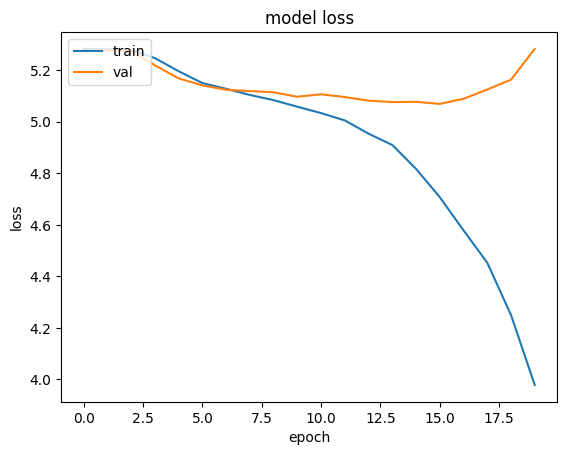

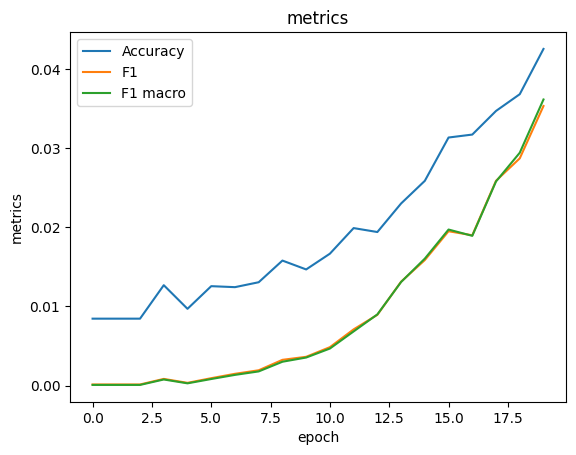

In [17]:
model = AlexNet(len(class_names)).to(device)
ce = torch.nn.CrossEntropyLoss()
adam = torch.optim.Adam(model.parameters(), lr=0.0005)
history = train_loop(model, train_loader, test_loader, adam, ce, 'alexnet_adam', 20)
plot_history(history)

In [18]:
! pip install pytorch_optimizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.8/155.8 kB 2.4 MB/s eta 0:00:00



Epoch 1:


100%|██████████| 16/16 [01:33<00:00,  5.82s/it]



😀 LOSS train: 5.278883248567581 valid 5.277271240949631
Accuracy: 0.0084566595
F1: 0.00014183077
F1 macro: 8.556881e-05

Epoch 2:


100%|██████████| 16/16 [01:21<00:00,  5.07s/it]



😀 LOSS train: 5.277794271707535 valid 5.276383578777313
Accuracy: 0.0084566595
F1: 0.00014183077
F1 macro: 8.556881e-05

Epoch 3:


100%|██████████| 16/16 [01:20<00:00,  5.03s/it]



😀 LOSS train: 5.2771309316158295 valid 5.275220185518265
Accuracy: 0.0084566595
F1: 0.00014183077
F1 macro: 8.556881e-05

Epoch 4:


100%|██████████| 16/16 [01:20<00:00,  5.06s/it]



😀 LOSS train: 5.276533156633377 valid 5.274527311325073
Accuracy: 0.0084566595
F1: 0.00014183077
F1 macro: 8.556881e-05

Epoch 5:


100%|██████████| 16/16 [01:21<00:00,  5.08s/it]



😀 LOSS train: 5.2745263278484344 valid 5.270900845527649
Accuracy: 0.0084566595
F1: 0.00014183077
F1 macro: 8.556881e-05

Epoch 6:


100%|██████████| 16/16 [01:21<00:00,  5.07s/it]



😀 LOSS train: 5.272790223360062 valid 5.264888793230057
Accuracy: 0.0084566595
F1: 0.00014183077
F1 macro: 8.556881e-05

Epoch 7:


100%|██████████| 16/16 [01:21<00:00,  5.07s/it]



😀 LOSS train: 5.265065938234329 valid 5.247581779956818
Accuracy: 0.0103221
F1: 0.0005586051
F1 macro: 0.00045193467

Epoch 8:


100%|██████████| 16/16 [01:21<00:00,  5.07s/it]



😀 LOSS train: 5.2672019302845 valid 5.250546306371689
Accuracy: 0.008332297
F1: 0.00079045305
F1 macro: 0.00075170305

Epoch 9:


100%|██████████| 16/16 [01:20<00:00,  5.06s/it]



😀 LOSS train: 5.261943697929382 valid 5.259131342172623
Accuracy: 0.009575923
F1: 0.0009757506
F1 macro: 0.0009728719

Epoch 10:


100%|██████████| 16/16 [01:21<00:00,  5.09s/it]



😀 LOSS train: 5.243770211935043 valid 5.262002170085907
Accuracy: 0.0098246485
F1: 0.0006799724
F1 macro: 0.00061747705

Epoch 11:


100%|██████████| 16/16 [01:20<00:00,  5.05s/it]



😀 LOSS train: 5.234769850969315 valid 5.223599344491959
Accuracy: 0.011690089
F1: 0.0016252061
F1 macro: 0.0015833118

Epoch 12:


100%|██████████| 16/16 [01:21<00:00,  5.07s/it]



😀 LOSS train: 5.24245223402977 valid 5.267062395811081
Accuracy: 0.007337396
F1: 0.0009657224
F1 macro: 0.0008747109

Epoch 13:


100%|██████████| 16/16 [01:21<00:00,  5.07s/it]



😀 LOSS train: 5.233883649110794 valid 5.198291718959808
Accuracy: 0.014799154
F1: 0.002759953
F1 macro: 0.0027998744

Epoch 14:


100%|██████████| 16/16 [01:20<00:00,  5.04s/it]



😀 LOSS train: 5.234478116035461 valid 5.258990913629532
Accuracy: 0.01268499
F1: 0.001505935
F1 macro: 0.0014221185

Epoch 15:


100%|██████████| 16/16 [01:20<00:00,  5.01s/it]



😀 LOSS train: 5.234622687101364 valid 5.216154754161835
Accuracy: 0.007834846
F1: 0.00083180564
F1 macro: 0.00076791615

Epoch 16:


100%|██████████| 16/16 [01:19<00:00,  4.97s/it]



😀 LOSS train: 5.188582479953766 valid 5.15845850110054
Accuracy: 0.014301703
F1: 0.0013766596
F1 macro: 0.0012911743

Epoch 17:


100%|██████████| 16/16 [01:20<00:00,  5.00s/it]



😀 LOSS train: 5.201062917709351 valid 5.2018763422966
Accuracy: 0.01318244
F1: 0.002026738
F1 macro: 0.0019301776

Epoch 18:


100%|██████████| 16/16 [01:19<00:00,  4.98s/it]



😀 LOSS train: 5.188128858804703 valid 5.275968283414841
Accuracy: 0.007586121
F1: 0.0009565939
F1 macro: 0.00088190084

Epoch 19:


100%|██████████| 16/16 [01:20<00:00,  5.00s/it]



😀 LOSS train: 5.2652632892131805 valid 5.235482007265091
Accuracy: 0.010073374
F1: 0.0014144911
F1 macro: 0.0015284976

Epoch 20:


100%|██████████| 16/16 [01:20<00:00,  5.03s/it]



😀 LOSS train: 5.229870587587357 valid 5.225485950708389
Accuracy: 0.010695187
F1: 0.002051795
F1 macro: 0.0019786302


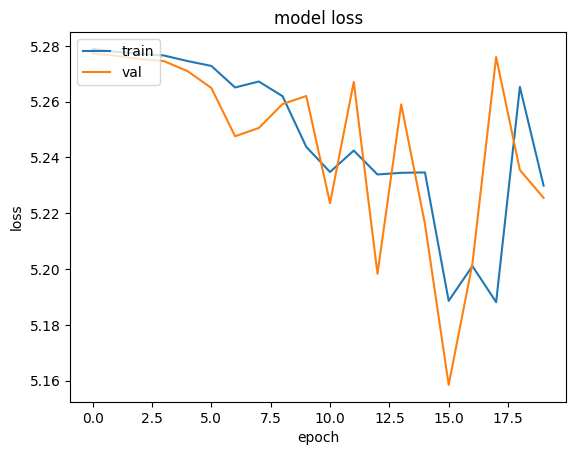

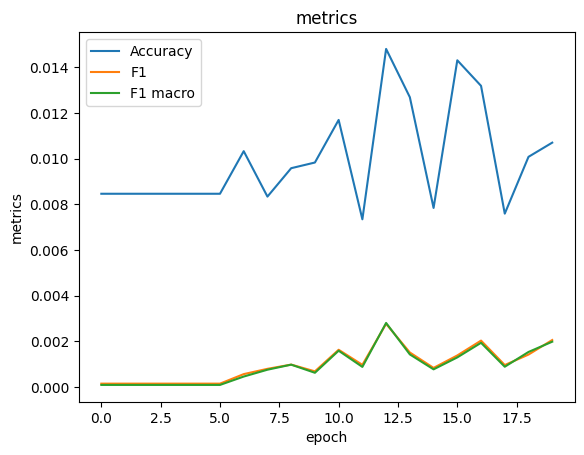

In [19]:
import pytorch_optimizer

model = AlexNet(len(class_names)).to(device)
ce = torch.nn.CrossEntropyLoss()
adasmooth = pytorch_optimizer.AdaSmooth(model.parameters(), lr = 0.0005)
history = train_loop(model, train_loader, test_loader, adasmooth, ce, 'alexnet_adasmooth', 20)
plot_history(history)

In [22]:
! cp alexnet_adam_16 /content/drive/MyDrive/saved_models

In [23]:
! cp alexnet_adasmooth_16 /content/drive/MyDrive/saved_models